## Multivariate time series prediction using Long Short Term Memory (LSTM)

### Theory of Recurrent Neural Network (RNN)

The most important difference between RNN and Fully Connected Network(FCN) is that RNN does sequential processing of input data and maintains a hidden state.
The hidden state is updated for each sequence input. When we train the model, it learns how to update the hidden state in the best possible way such that it can be used to predict the next value in the sequence. Basic example:

### Let's consider a network that learns to count the number of 1's in a binary sequence.

So, in an FCN, we feed the entire binary sequence at once, e.g. 1, 0, 1, 1 is fed at once, and it multiplies with a weight matrix of a 4x4 matrix and the computes flows forward.

But, in a LSTM, 
- Model first takes 1 and an initial hidden state h which is normally assigned to be 0, updates the hidden state h,
- Then takes 0 and h and updates hidden state h,
- Then takes 1 and h updates hidden state h,
- Also finally takes 1 and h and updates the hidden state h.

  This final h value is used to predict the number of 1's in the binary sequence. Normally this h is passed through a fully connected layer to get the required final output.

Mathematically,

$$ h_t = W_{xh}x_t + b_t + W_{hh} h_{t-1} + b_h $$

Final output is calculated as
$$ y_t = h_t W_{hy}^T + b_y $$

Here is a PyTorch implementation of an LSTM neural network which has 1 LSTM layer and 1 fully connected layer.


### LSTM

LSTM is basically an RNN where the way we calculate the hidden state is more advanced and involves multiple equations. In practice, LSTM has been implemented in different time series modeling applications. Pytorch implementation of LSTM uses the following equations in each layer.

We initialize the $h_{t-1}$ and $c_{t-1}$ to zeros in every forward pass
$$\begin{array}{ll} \\
         Input Gate:   i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
         Forget Gate:   f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
         Candidate Cell State:   g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
         Output Gate:   o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
         Cell State Update:   c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
         Hidden State:   h_t = o_t \odot \tanh(c_t) \\
        \end{array}$$



In [1]:
import torch
import numpy as np

import pandas as pd
from sklearn.preprocessing import MinMaxScaler


In [2]:
path = 'final_data.csv'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Implement determinism. Set a fixed value for random seed so that when the parameters are initialized, they are initialized same across all experiments.
torch.manual_seed(42)

# If you are using CUDA, also set the seed for it
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Set the seed for NumPy
np.random.seed(42)

Using device: cuda


Here we define **RiverData** a custom Dataset class to load the dataset we have. It extends the Pytorch Dataset class.  
- We need to define \_\_init__() function which can be used for loading data from the file and optionally for data preprocessing.
- Thereafter we define \_\_len__() function which gives the length of dataset.
- Then we define \_\_getitem__() function which returns an instance of (feature, label) tuple which can be used for model training.
  For our time series data, feature means the past values to be used for training and label means the future values to be predicted.

In [4]:
class RiverData(torch.utils.data.Dataset):
    
    def __init__(self, df, target, datecol, seq_len, pred_len):
        self.df = df
        self.datecol = datecol
        self.target = target
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.setIndex()
        

    def setIndex(self):
        self.df.set_index(self.datecol, inplace=True)
    

    def __len__(self):
        return len(self.df) - self.seq_len - self.pred_len


    def __getitem__(self, idx):
        if len(self.df) <= (idx + self.seq_len+self.pred_len):
            raise IndexError(f"Index {idx} is out of bounds for dataset of size {len(self.df)}")
        df_piece = self.df[idx:idx+self.seq_len].values
        feature = torch.tensor(df_piece, dtype=torch.float32)
        label_piece = self.df[self.target][idx + self.seq_len:  idx+self.seq_len+self.pred_len].values
        label = torch.tensor(label_piece, dtype=torch.float32)
        return (feature, label) 

### Normalize the data

In [5]:
df = pd.read_csv(path)
raw_df = df.drop('DATE', axis=1, inplace=False)
scaler = MinMaxScaler()

# Apply the transformations
df_scaled = scaler.fit_transform(raw_df)

df_scaled = pd.DataFrame(df_scaled, columns=raw_df.columns)
df_scaled['DATE'] = df['DATE']
df = df_scaled

Some advanced Python syntax has been used here. \
*common_args : it's used to pass arguments to a function, where common_args represents a python list \
**common_args: it's used to pass arguments to a function, where common_args represents a python dictionary

In [6]:

train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

seq_len = 13
pred_len = 1
num_features = 7

common_args = ['gauge_height', 'DATE', seq_len, pred_len]
train_dataset = RiverData(df[:train_size], *common_args)
val_dataset = RiverData(df[train_size: train_size+val_size], *common_args)
test_dataset = RiverData(df[train_size+val_size : len(df)], *common_args)


In [7]:
# Important parameters

BATCH_SIZE = 512 # keep as big as can be handled by GPU and memory
SHUFFLE = False # we don't shuffle the time series data
DATA_LOAD_WORKERS = 1 # it depends on the amount of data you need to load
learning_rate = 0.001029
weight_decay = 0.00025039


In [8]:
from torch.utils.data import DataLoader

common_args = {'batch_size': BATCH_SIZE, 'shuffle': SHUFFLE}
train_loader = DataLoader(train_dataset, **common_args)
val_loader = DataLoader(val_dataset, **common_args)
test_loader = DataLoader(test_dataset, **common_args)

### Here we define our PyTorch model.

BasicLSTMNetwork is the model class, it extends the Module class provided by pytorch. \
- We define \_\_init__() function. It sets up layers and defines the model parameters.
- Also, we define forward() function which defines how the forwared pass computation occurs

In [9]:
class BasicLSTMNetwork(torch.nn.Module):
    
    def __init__(self, seq_len, pred_len):
        # call the constructor of the base class
        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_features = num_features
        self.n_layers = 1
        
        self.n_hidden = 128
        
        # define layers for combining across time series
        self.lstm1 = torch.nn.LSTM(input_size = self.num_features, hidden_size = self.n_hidden, num_layers=self.n_layers, batch_first = True)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(self.n_hidden * self.seq_len, self.pred_len)


    def init_hidden(self, batchsize):
        device = next(self.parameters()).device
        hidden_state = torch.zeros(self.n_layers, batchsize, self.n_hidden, device=device)
        cell_state = torch.zeros(self.n_layers, batchsize, self.n_hidden, device=device)
        return hidden_state, cell_state

    
    def forward(self, x):
        batchsize, seqlen, featlen = x.size()
        self.hidden_states = self.init_hidden(batchsize)
        lstm_out, self.hidden_states = self.lstm1(x, self.hidden_states)
        lstm_out = lstm_out.contiguous().view(batchsize, -1)
        lstm_out = self.relu(lstm_out)
        lstm_out = self.fc1(lstm_out)
        return lstm_out
# Note that the gradients are stored insize the FC layer objects
# For each training example we need to get rid of these gradients

In [10]:
model = BasicLSTMNetwork(seq_len, pred_len)
model = model.to(device)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

In [11]:
for gen in model.parameters():
    print(gen.shape)

torch.Size([512, 7])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([1, 1664])
torch.Size([1])


In [12]:
for i, (f,l) in enumerate(train_loader):
    print('features shape: ', f.shape)
    print('labels shape: ', l.shape)
    break

features shape:  torch.Size([512, 13, 7])
labels shape:  torch.Size([512, 1])


In [13]:
# define metrics
import numpy as np
import matplotlib.pyplot as plt
epsilon = np.finfo(float).eps

def wape_function(y, y_pred):
    """Weighted Average Percentage Error metric in the interval [0; 100]"""
    y = np.array(y)
    y_pred = np.array(y_pred)
    nominator = np.sum(np.abs(np.subtract(y, y_pred)))
    denominator = np.add(np.sum(np.abs(y)), epsilon)
    wape = np.divide(nominator, denominator) * 100.0
    return wape

def nse_function(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    return (1-(np.sum((y_pred-y)**2)/np.sum((y-np.mean(y))**2)))


def evaluate_model(model, data_loader, plot=False):
    # following line prepares the model for evaluation mode. It disables dropout and batch normalization if they have 
    # are part of the model. For our simple model, it's not necessary. Still, I'm going to use it.

    model.eval()
    all_inputs = torch.empty((0, seq_len, num_features))
    all_labels = torch.empty(0, pred_len)
    for inputs, labels in data_loader:
        all_inputs = torch.vstack((all_inputs, inputs))
        all_labels = torch.vstack((all_labels, labels))
    
    with torch.no_grad():
        all_inputs = all_inputs.to(device)
        outputs = model(all_inputs).detach().cpu()
        avg_val_loss = loss(outputs, all_labels)
        nse = nse_function(all_labels.numpy(), outputs.numpy())
        wape = wape_function(all_labels.numpy(), outputs.numpy())
        
    print(f'NSE : {nse}', end=' ')
    print(f'WAPE : {wape}', end=' ')
    print(f'Validation Loss: {avg_val_loss}')
    model.train()

    if plot:
        plt.plot(np.array(all_labels.cpu()[:100]), color='green', label='observations')
        plt.plot(np.array(outputs.cpu()[:100]), color='red', linestyle='-', label='predictions')
        metrics_text = f"NSE: {nse:.3f}\nWAPE: {wape:.3f}" 
        plt.text(0.28, 0.97, metrics_text, transform=plt.gca().transAxes, 
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        plt.legend()
        plt.show()
    
    return avg_val_loss


In [14]:
num_epochs = 200
best_val_loss = float('inf')
patience = 5

for epoch in range(num_epochs):
    epoch_loss = []
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss_val = loss(outputs, labels)

        # calculate gradients for back propagation
        loss_val.backward()

        # update the weights based on the gradients
        optimizer.step()

        # reset the gradients, avoid gradient accumulation
        optimizer.zero_grad()
        epoch_loss.append(loss_val.item())

    avg_train_loss = sum(epoch_loss)/len(epoch_loss)
    print(f'Epoch {epoch+1}: Traning Loss: {avg_train_loss}', end=' ')
    avg_val_loss = evaluate_model(model, val_loader)

    # Check for improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            # Load the best model before stopping
            model.load_state_dict(torch.load('best_model.pth'))
            break

Epoch 1: Traning Loss: 0.010294056857692616 NSE : 0.37985968589782715 WAPE : 46.75522223231724 Validation Loss: 0.010587356984615326
Epoch 2: Traning Loss: 0.006346115971138927 NSE : 0.8287148475646973 WAPE : 21.759571304714676 Validation Loss: 0.002924269298091531
Epoch 3: Traning Loss: 0.0018032588547986204 NSE : 0.9086541831493378 WAPE : 15.263833307626266 Validation Loss: 0.0015595033764839172
Epoch 4: Traning Loss: 0.0011198646503812067 NSE : 0.9362273141741753 WAPE : 12.36241106411061 Validation Loss: 0.0010887605603784323
Epoch 5: Traning Loss: 0.0009349160148483833 NSE : 0.9455853551626205 WAPE : 11.503226060909551 Validation Loss: 0.0009289951412938535
Epoch 6: Traning Loss: 0.0008195572241158036 NSE : 0.9524189084768295 WAPE : 10.779609523729032 Validation Loss: 0.0008123291190713644
Epoch 7: Traning Loss: 0.0007343628204778973 NSE : 0.956009816378355 WAPE : 10.450030830873553 Validation Loss: 0.0007510232971981168
Epoch 8: Traning Loss: 0.0006622869308936282 NSE : 0.95947332

NSE : 0.9588164836168289 WAPE : 8.29375799889384 Validation Loss: 0.00044969632290303707


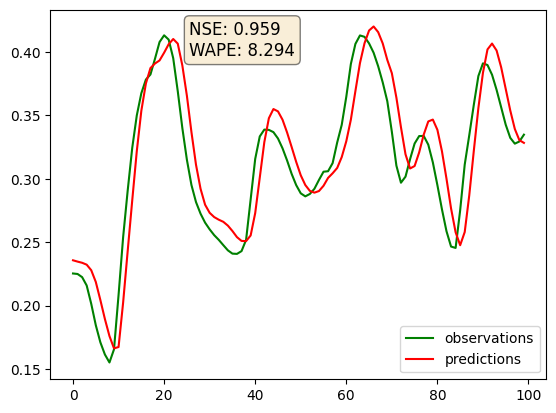

tensor(0.0004)

In [17]:
evaluate_model(model, test_loader, plot=True)